# RAGAS Customization
### 실제 사용자 질의와 ragas 평가용 질의의 간극 해소
* 문서를 통한 페르소나 생성이 아닌, 직접 페르소나를 설정하여 생성 데이터의 현실성 제고
  * RAG 시스템의 실제 사용자를 기준으로 페르소나를 설정
  * 페르소나의 운동 수준, 관심사, 신체 특성 등 다양한 조건을 반영
* 온톨로지 중심 사용자 질의 모델링을 통한 생성 데이터의 현실성 제고
  * 사용자의 실제 질의에 자주 등장하고, 문서 전체에 고르게 분포하는 entity 온톨로지(예: 운동명, 운동 구간, 신체 부위) 구성
  * 표준 용어집을 활용한 entity 정규화로 지식그래프 연결성 강화

### 동일 키워드에 대한 복합 주제(Multi-Section) 질의 생성
* MultiHopSpecific Type의 동일 섹션 결합 질의 집중화 해결을 위한 RAGAS Customize 진행
* ex) "**sumo 데드리프트의 마무리 동작에서 허리**에 과도한 무게 집중이 나타나고 있어. 이 현상이 나타나는 **과학적 이유**와 이를 해결하기 위한 **연습 방법**을 작성해줘."
  * 중심 키워드: sumo 데드리프트(운동명), 마무리 동작(운동 구간), 허리(신체 부위)
  * 주제: 과학적 이유(2 단원), 연습 방법(3 단원)

In [1]:
import os
import pandas as pd
import json
import math
import random
from tqdm import tqdm

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import sys
sys.path.append('../code/ragas_custom')

from analyze_knowledgeGraph.relation import analyze_relationship, analyze_sector_connection_ratio
from analyze_knowledgeGraph.node import analyze_node_entity
from generate_dataset.utils import translate, analyze_synthetic_data

In [2]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

from ragas.testset.graph import KnowledgeGraph
from ragas.testset.graph import Node, NodeType

generator_llm = LangchainLLMWrapper(ChatOpenAI(model='gpt-4o-mini'))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

kg = KnowledgeGraph.load('../data/document/역도/kg.json')

c:\Users\owner\anaconda3\envs\SportAgent\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 문서 기반 페르소나 생성이 아닌 RAG 시스템 사용자 페르소나 설정
* 실 사용자를 예상하여 페르소나 설정
* 사용자의 운동수준, 신체조건, 관심사항 등을 반영

### 페르소나 목록
1. **일반 피트니스 초보자**: 비운동 경력자이며 건강 및 체력 향상을 위해 역도를 시작함. 쉬운 언어와 안전성에 대한 확신이 필요함.
2. **다이어트 목적의 초보자**: 체형 변화와 체중 감량이 주요 목적이며 역도 운동 기반 체중감량을 위한 루틴 및 식단 계획에 관심 많음.
3. **홈트레이닝 초보자**: 헬스장을 이용하지 않고 집에서 역도 운동을 시작하려는 사용자. 최소 장비로 가능한 대체 운동에 관심 있음.
4. **중장년 초보자**: 40~60대 이상의 사용자로, 부상 예방과 자세 교정에 민감함.
5. **피트니스 센터 초보자**: 헬스장에서 기초적인 트레이닝을 받았으나, 역도 운동은 처음인 초보자. 자세와 피드백에 관심 많음.
6. **역도 선수 지망 청소년**: 체육 계열 진학을 준비 중인 청소년. 실기시험에서 역도 관련 사항에 대한 부담을 느끼는 심리상태.
7. **아마추어 역도 대회 참가자**: 생활체육 대회의 역도종목을 준비하며 감량 및 대회 직전 루틴 계획에 관심 있음.
8. **역도 퍼포먼스 추구자**: 역도 스포츠에서 단순 기록 향상보다는 기술 완성도를 추구하며, 운동 역학 기반 피드백을 원함.

In [3]:
from ragas.testset.persona import Persona

persona_general_fitness_beginner = Persona(
    name="General Fitness Beginner",
    role_description="A non-athletic person starting weightlifting for general health and fitness improvement. Needs simple explanations and safety assurance, interested in basic exercise methods and precautions.",
)

persona_diet_motivated_beginner = Persona(
    name="Diet-Motivated Beginner",
    role_description="Primary goal is body transformation and weight loss, interested in weightlifting-based routines and diet plans. Values information about exercise effectiveness and calorie consumption.",
)

persona_home_training_beginner = Persona(
    name="Home Training Beginner",
    role_description="User who wants to start weightlifting at home without going to the gym. Looking for alternative exercises with minimal equipment and workout methods within space constraints.",
)

persona_middle_aged_beginner = Persona(
    name="Middle-Aged Beginner",
    role_description="User aged 40-60+ who is sensitive to injury prevention and posture correction. Pursues safe exercise methods considering joint health and overall physical condition.",
)

persona_fitness_gym_novice = Persona(
    name="Fitness Gym Novice",
    role_description="Beginner who has received basic training at the gym but is new to weightlifting. Hopes for proper feedback on form and movement.",
)

persona_youth_athlete_aspirant = Persona(
    name="Youth Weightlifting Aspirant",
    role_description="Teenager preparing for physical education-related college admission, interested in natural connection movements.",
)

persona_amateur_competitor = Persona(
    name="Amateur Weightlifting Competitor",
    role_description="Preparing for amateur weightlifting competitions, interested in weight management and pre-competition routine planning. Needs information about competition preparation process and weight management.",
)

persona_performance_optimizer = Persona(
    name="Weightlifting Performance Optimizer",
    role_description="Pursues technical perfection rather than just record improvement in weightlifting, seeks biomechanical-based feedback. Demands detailed analysis of accurate posture and efficient movement.",
)

personas = [persona_general_fitness_beginner,
    persona_diet_motivated_beginner,
    persona_home_training_beginner,
    persona_middle_aged_beginner,
    persona_fitness_gym_novice,
    persona_youth_athlete_aspirant,
    persona_amateur_competitor,
    persona_performance_optimizer]

## 2. 정보 추출
* 특정 단원이 아닌, 문서 전체에 골고루 배출되어 있는 Entity를 선택
* 사용자 예상 질문과 관련해, 시나리오 구성을 위한 정보 추출

### Entity 목록
* 운동명(exercise_name)
  * 종목 또는 기술 종목 구분, 세부 운동 이름
  * Snatch, Clean, Jerk, Power Snatch, Front Squat, Snatch Pull 등
* 운동 세부 구간(exercise_phase)
  * Start Position, First Pull, Second Pull, Lockout, Recovery, 1구간, 2구간, 3구간 등
* 신체부위(body_part)
  * 사용하거나 강화하는 근육, 주요 관절, 신체부위명
  * 광배근, 복직근, 대퇴이두근, 무릎 신전, 고관절 굴곡, 발목 신전, 어깨, 무릎, 손목

In [4]:
from pydantic import BaseModel
from typing import List, Tuple, Type, Dict, Any
from dataclasses import dataclass
from ragas.prompt import PydanticPrompt
from ragas.testset.transforms.base import LLMBasedExtractor
from ragas.testset.transforms.extractors.llm_based import TextWithExtractionLimit
from ragas.testset.transforms import apply_transforms

class CustomNEROutput(BaseModel):
    exercise_name: List[str]
    exercise_phase: List[str]
    body_part: List[str]

class CustomNERPrompt(PydanticPrompt[TextWithExtractionLimit, CustomNEROutput]):
    instruction: str = (
        "Extract named entities from the given text and classify them into the following three categories:\n\n"
        "1) exercise_name: Names of sports movements or technical weightlifting exercises.\n"
        "   - Example: Snatch, Clean, Jerk, Power Snatch, Front Squat, Snatch Pull, 용상, 인상\n\n"
        "2) exercise_phase: Specific stages or segments within an exercise movement.\n"
        "   - Example: Start Position, First Pull, Second Pull, Lockout, Recovery, 1구간, 2구간, 3구간\n\n"
        "3) body_part: Related anatomical terms, including muscles, joint actions, and body parts involved in weightlifting movements.\n"
        "   - Example: 광배근, 복직근, 대퇴이두근, quadriceps, hamstrings, wrist extension, hip flexion, knees, shoulders, ankles\n\n"
        "Make sure to accurately classify extracted entities into these categories. "
        "Limit the number of entities extracted per category according to the specified maximum."
    )
    input_model: Type[TextWithExtractionLimit] = TextWithExtractionLimit
    output_model: Type[CustomNEROutput] = CustomNEROutput
    examples: List[Tuple[TextWithExtractionLimit, CustomNEROutput]] = [
        (
            TextWithExtractionLimit(
                text=(
                    "클린 동작의 스타트 포지션에서는 발바닥 전체에 체중을 싣고 대퇴사두근을 활용하여 초반 힘을 전달해야 합니다. "
                    "세컨드 풀에서는 무릎과 고관절을 폭발적으로 펴면서 빠른 속도로 바를 들어올려야 하며, 이 과정에서 훅 그립을 유지하는 것이 중요합니다. "
                    "힙 플렉션과 손목의 안정성은 캐치 구간으로 전환할 때 부드러운 연결을 만들어줍니다. "
                    "최종적으로 팔꿈치를 빠르게 바벨 아래로 밀어넣어 프론트 랙 자세를 완성해야 합니다."
                ),
                max_num=15,
            ),
            CustomNEROutput(
                exercise_name=["클린"],
                exercise_phase=["스타트 포지션", "세컨드 풀", "캐치 구간"],
                body_part=["대퇴사두근", "무릎", "고관절", "힙 플렉션", "손목", "팔꿈치"],
            ),
        ),
        (
            TextWithExtractionLimit(
                text=(
                    "세컨드 풀 단계에서는 고관절과 무릎의 강력한 신전이 필요합니다. "
                    "동시에 발목 플랜타플렉션이 일어나며 몸 전체가 수직 방향으로 힘을 전달하게 됩니다. "
                    "어깨와 손목의 안정성이 유지되어야 바벨과 몸의 중심이 일치할 수 있습니다."
                ),
                max_num=15,
            ),
            CustomNEROutput(
                exercise_name=[],
                exercise_phase=["세컨드 풀"],
                body_part=["고관절", "무릎", "발목 플랜타플렉션", "어깨", "손목"],
            ),
        )
    ]


@dataclass
class CustomERExtractor(LLMBasedExtractor):
    """
    Extracts entities in three categories: exercise_name, exercise_phase, body_part.
    """
    property_name: str = "exercise_entities"
    prompt: PydanticPrompt[TextWithExtractionLimit, CustomNEROutput] = CustomNERPrompt()
    max_num_entities: int = 20  # per category

    async def extract(self, node: Node) -> Dict[str, List[str]]:
        heading = '\n'.join([item for key, item in node.properties['document_metadata']['heading'].items() if not item is None])
        node_text = node.get_property("page_content") or ""
        text = heading + '\n' + node_text

        all_entities: Dict[str, List[str]] = {
            "exercise_name": [],
            "exercise_phase": [],
            "body_part": [],
        }

        if node_text == "":
            return self.property_name, all_entities

        result: CustomNEROutput = await self.prompt.generate(
            self.llm,
            data=TextWithExtractionLimit(
                text=text,
                max_num=self.max_num_entities
            ),
        )
        all_entities["exercise_name"].extend(result.exercise_name)
        all_entities["exercise_phase"].extend(result.exercise_phase)
        all_entities["body_part"].extend(result.body_part)

        return self.property_name, all_entities

In [5]:
from langchain_openai import ChatOpenAI
from ragas.llms import LangchainLLMWrapper
from ragas.testset.transforms import apply_transforms

from ragas.testset.transforms.extractors.embeddings import EmbeddingExtractor
from ragas.testset.transforms.extractors.llm_based import (
    SummaryExtractor,
    ThemesExtractor
)

llm = LangchainLLMWrapper(ChatOpenAI())

customER_extractor = CustomERExtractor(llm=generator_llm)

transforms = [
    customER_extractor,
]

# apply_transforms(kg, transforms=transforms)
# kg.save('../data/document/역도/kg.json')

In [6]:
# kg = KnowledgeGraph.load('../data/document/역도/kg.json')

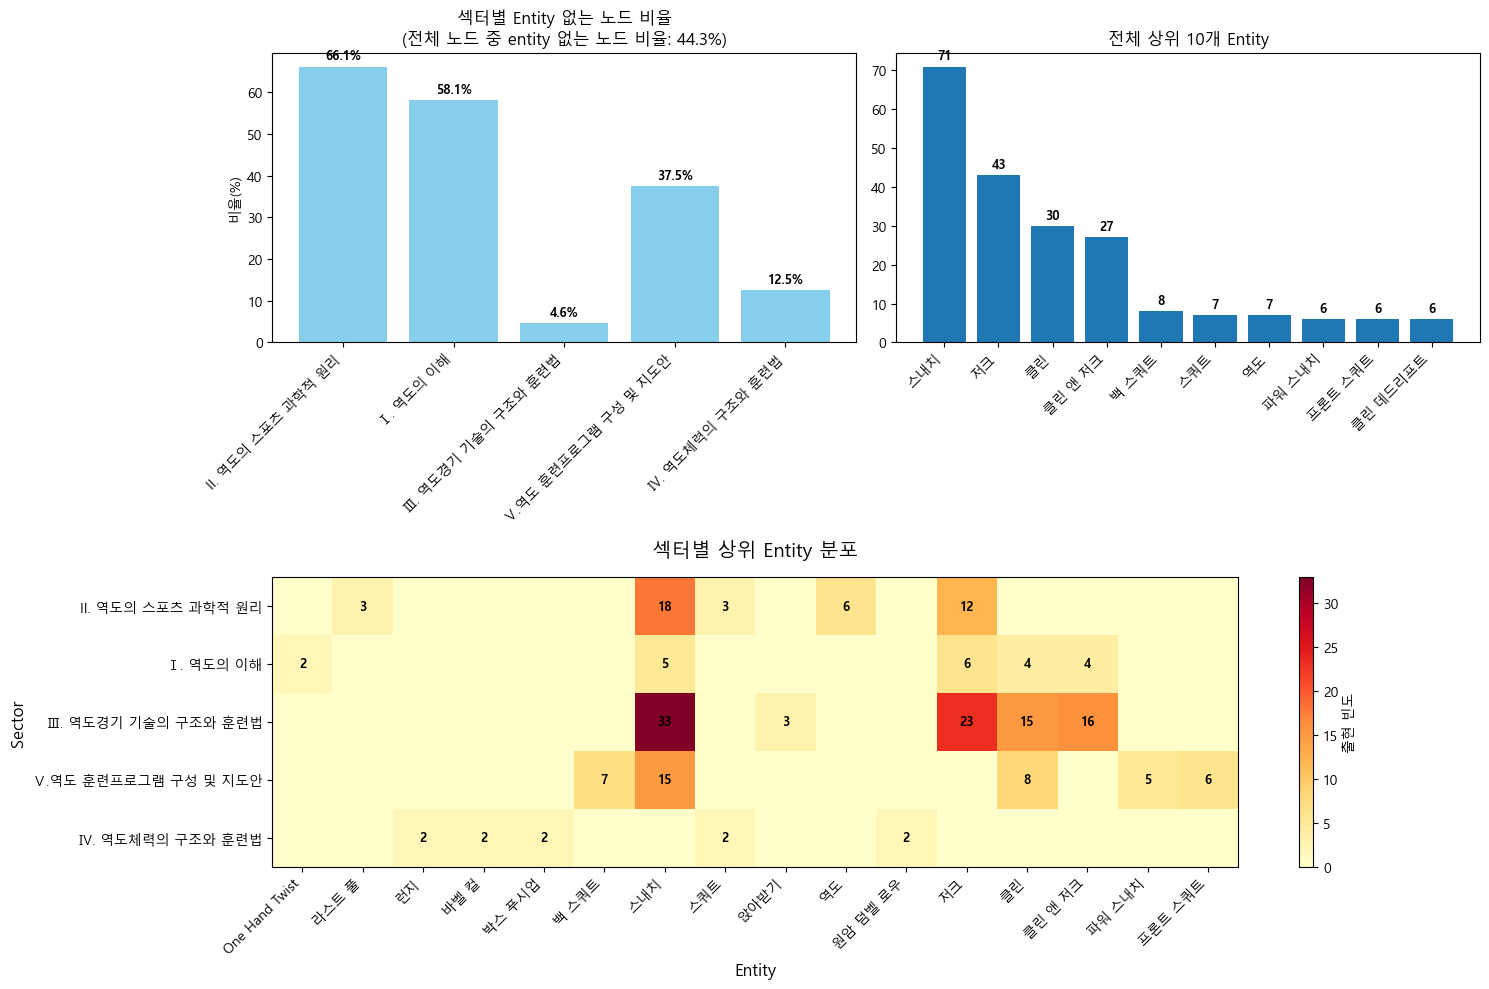

전체 노드 수: 255
Entity가 없는 노드 수: 113
전체 노드 중 entity가 없는 노드 비율: 44.3%


In [8]:
analyze_node_entity(kg, 'exercise_name')

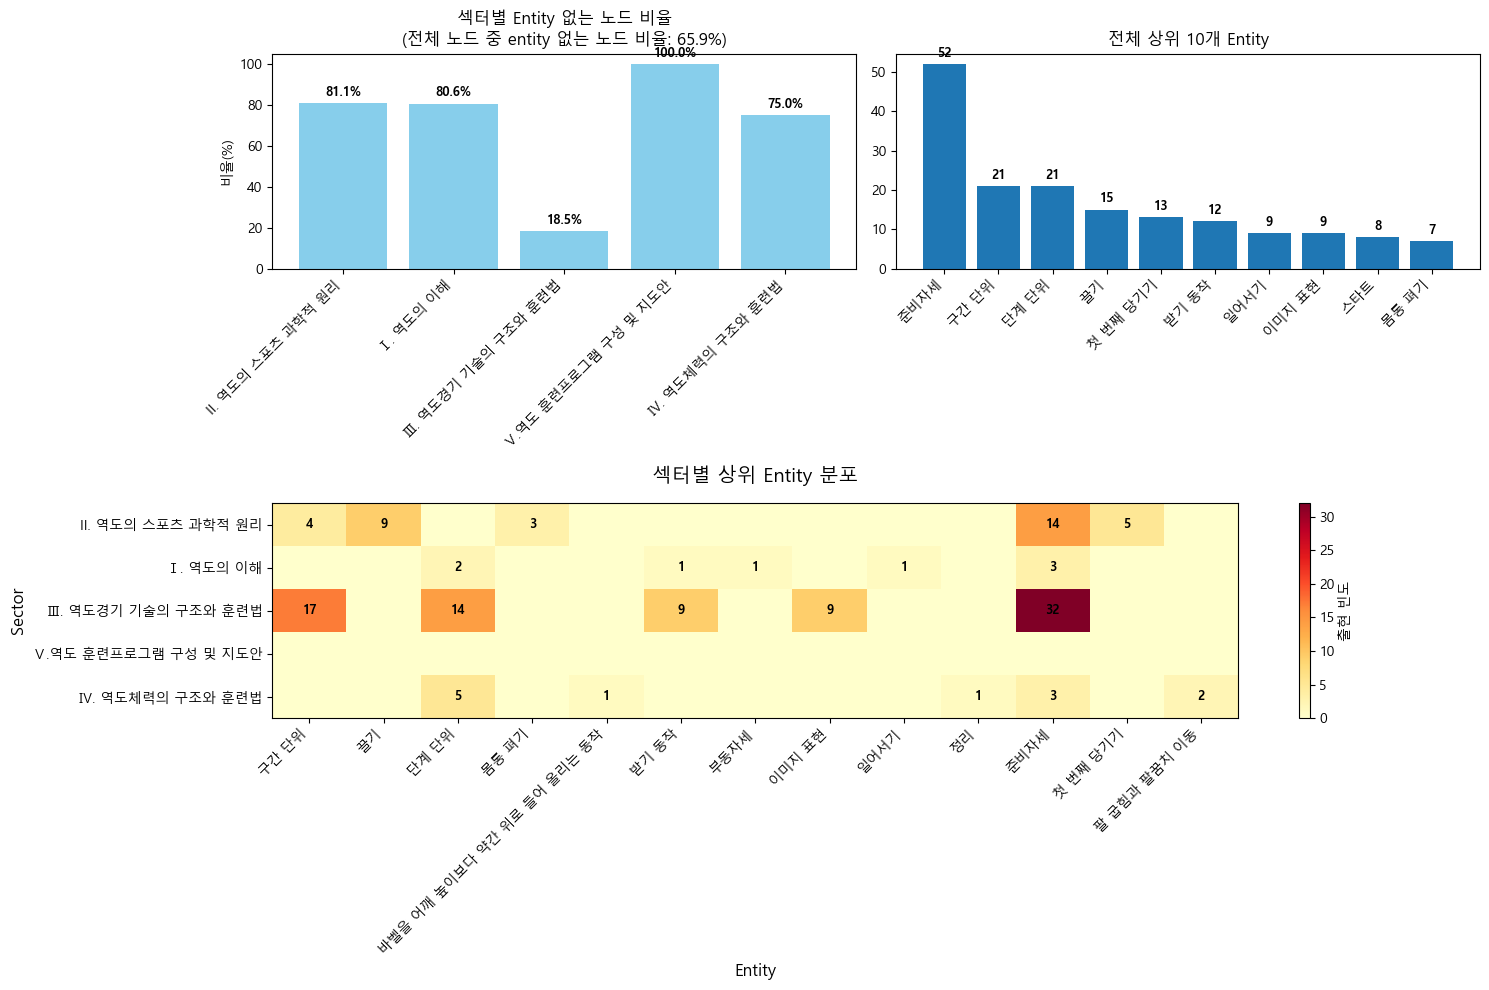

전체 노드 수: 255
Entity가 없는 노드 수: 168
전체 노드 중 entity가 없는 노드 비율: 65.9%


In [9]:
analyze_node_entity(kg, 'exercise_phase')

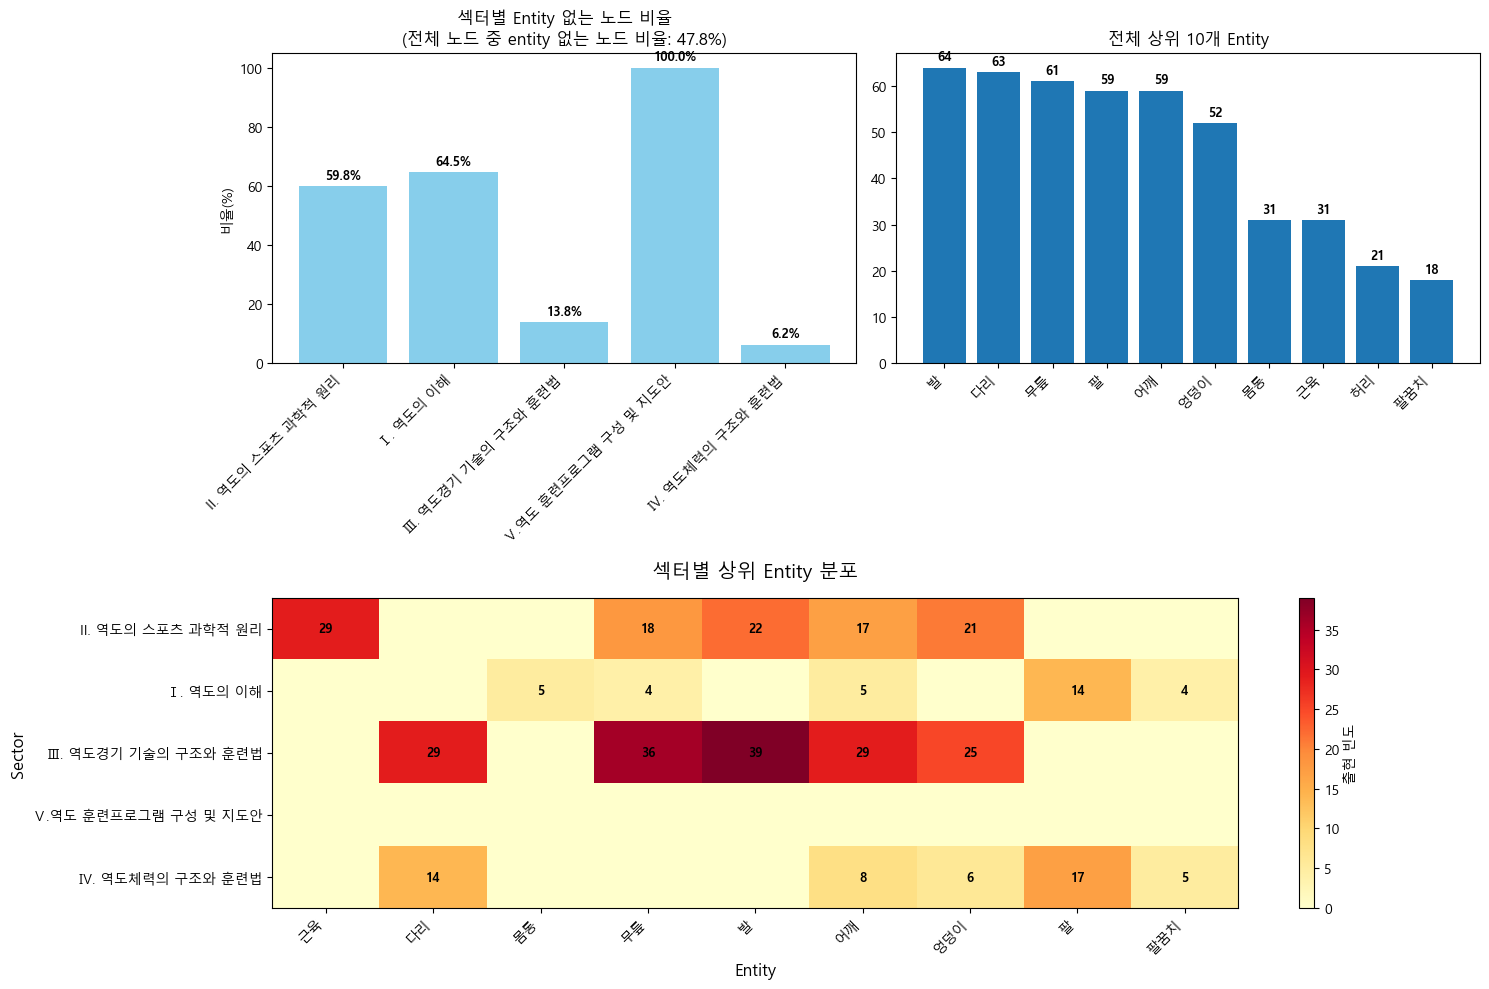

전체 노드 수: 255
Entity가 없는 노드 수: 122
전체 노드 중 entity가 없는 노드 비율: 47.8%


In [10]:
analyze_node_entity(kg, 'body_part')

## 3. 관계형성
* RAGAS에서 제공하는 NER 기반의 관계형성 방법인 OverlapScoreBuilder를 변형해, 서로 다른 section간 연결 증대
  * 개체명 정규화, 기존 get_noisy_item(자주 등장하는 엔티티 필터링) 기능 제거
  * 기존 알고리즘 대비 관계수 ()% 증가

### 기존 OverlapScoreBuilder
* exercise_name: 327 개
* exercise_phase: 255 개
* body_part: 1256개
* 총 1838 개
* 

### 표준 용어집 적용

In [11]:
name_dict = {
    "Snatch": "스내치",
    "snatch": "스내치",
    "Snatch high Pull": "스내치",
    "Snatch Pull": "스내치",
    "스내치 풀": "스내치",
    "잡아채기": "스내치",
    "인상": "스내치",
    "인상동작": "스내치",
    "인상기술": "스내치",
    
    "Clean": "클린",
    "clean": "클린",
    "Top Clean": "클린",
    "High Clean": "클린",
    "High Clean from Hang": "클린",
    "Clean Pull": "클린",
    "Clean high Pull": "클린",
    "클린 풀": "클린",
    "클린동작": "클린",
    
    "Jerk": "저크",
    "jerk": "저크",
    "Jerk Dip": "저크",
    "Jerk Balance": "저크",
    "Jerk Recovery": "저크",
    "Jerk Up": "저크",
    "Jerk Split": "저크",
    "저크 딥": "저크",
    "저크딥": "저크",
    "저크 업": "저크",
    "저크업": "저크",
    "저크 스프리트": "저크",
    "저크스플릿": "저크",
    "저크동작": "저크",

    "Clean and Jerk": "클린 앤 저크",
    "Clean & Jerk": "클린 앤 저크",
    "clean and jerk": "클린 앤 저크",
    "클린 앤 저크": "클린 앤 저크",
    "용상": "클린 앤 저크",

    "Front Squat": "프론트 스쿼트",
    "프론트 스쿼트": "프론트 스쿼트",

    "Back Squat": "백 스쿼트",
    "백 스쿼트": "백 스쿼트",

    "Squat": "스쿼트",
    "스쿼트": "스쿼트",
    "하프 스쿼트": "스쿼트",
    "하프-스쿼트": "스쿼트",

    "Power Clean": "파워 클린",
    "파워 클린": "파워 클린",

    "Power Snatch": "파워 스내치",
    "Power snatch": "파워 스내치",
    "파워 스내치": "파워 스내치",

    "Push Press": "푸시 프레스",
    "푸시 프레스": "푸시 프레스",

    "Push Jerk": "푸시 저크",
    "푸시 저크": "푸시 저크",

    "Split Jerk": "저크 스플릿",
    "저크 스플릿": "저크 스플릿",

    "Snatch Balance": "스내치 밸런스",
    "스내치 밸런스": "스내치 밸런스",

    "Clean Deadlift": "클린 데드리프트",
    "Straight Clean Deadlift": "클린 데드리프트",
    "데드 리프트": "클린 데드리프트",

    "Snatch Deadlift": "스내치 데드리프트",
    "Snatch Dead Lift": "스내치 데드리프트",
    "스내치 데드리프트": "스내치 데드리프트",

    "Good Morning-Exercise": "굿모닝",
    "Good Morning": "굿모닝",

    "Military Press": "밀리터리 프레스",
    "밀리터리 프레스": "밀리터리 프레스",

    "One Arm Dumbbell Row": "원암 덤벨 로우",
    "One Hand Clean": "원암 덤벨 로우",
    "Bent-Over Row": "원암 덤벨 로우",

    "Lat Pull Down": "랫풀다운",

    "Leg Curl": "레그 컬",
    "레그 컬": "레그 컬",

    "Leg Press": "레그 프레스",
    "레그 프레스": "레그 프레스",

    "Sit-up": "싯업",
    "윗몸일으키기": "싯업",
    "싯업": "싯업",

    "Hyper-extension": "하이퍼 익스텐션",
    "Back Hyper-extension": "하이퍼 익스텐션",
    "하이퍼 익스텐션": "하이퍼 익스텐션",

    "Step Up": "스텝 업",

    "Forward Lunge": "런지",

    "Bench Press": "벤치 프레스",
    "Flat Barbell Bench Press": "벤치 프레스",
    "Incline Barbell Bench Press": "벤치 프레스",
    "벤치 프레스": "벤치 프레스",

    "바벨 컬": "바벨 컬",
    "컬": "바벨 컬",
    "트라이셉스 컬 바": "바벨 컬",

    "Pull-up": "턱걸이",
    "턱걸이": "턱걸이",

    "덤벨 레터럴 레이즈": "레터럴 레이즈",

    "Jump Snatch": "점프 스내치",
    "점프 스내치": "점프 스내치",

    "Jump Clean (on disk)": "점프 클린",
    "점프 클린": "점프 클린",

    "스프린트": "스프린트",

    "플라이오메트릭": "플라이오메트릭",

    "웨이트 트레이닝": "웨이트 트레이닝",
    "웨이트트레이닝": "웨이트 트레이닝",

    "등속성 운동": "등속성 운동",
    "등속성 훈련": "등속성 운동",

    "등척성 운동": "등척성 운동",

    "등장성 운동": "등장성 운동"
}

In [12]:
phase_dict = {
    "스타트 자세": "준비자세",
    "스타트자세": "준비자세",
    "시작 자세": "준비자세",
    "시작자세": "준비자세",
    "출발 자세": "준비자세",
    "출발자세": "준비자세",
    "준비 자세": "준비자세",
    "준비자세": "준비자세",
    "예비자세": "준비자세",
    "예비동작": "준비자세",

    "스타트": "스타트",
    "출발단계": "스타트",
    "초기 동작": "스타트",
    "정적인 시작": "스타트",
    "정지하기": "스타트",

    "first pull": "첫 번째 당기기",
    "첫 번째 Pull 단계": "첫 번째 당기기",
    "무릎높이까지 끌기": "첫 번째 당기기",
    "무릎높이까지 들어올리기": "첫 번째 당기기",
    "지면-무릎": "첫 번째 당기기",
    "무릎 구간": "첫 번째 당기기",
    "무릎구간": "첫 번째 당기기",

    "second pull": "두 번째 당기기",
    "라스트 풀": "두 번째 당기기",
    "최대 발목 신전": "두 번째 당기기",
    "최대로 들어 올린 상태": "두 번째 당기기",
    "정점에서": "두 번째 당기기",
    "풀 익스텐션": "두 번째 당기기",

    "끌기": "끌기",
    "끌기 자세": "끌기",
    "끌기동작": "끌기",
    "끌기자세": "끌기",
    "무릎 넣기": "끌기",
    "무릎 넣기 동작": "끌기",

    "몸통 펴기": "몸통 펴기",
    "몸통펴기": "몸통 펴기",
    "몸통 펴기 구간": "몸통 펴기",
    "몸통 완전히 펴기": "몸통 펴기",
    "몸통 펴고 잡아채기": "몸통 펴기",
    "몸통 펴고 잡아채기 자세": "몸통 펴기",

    "팔꿈치 올리기": "팔 굽힘과 팔꿈치 이동",
    "팔 구부리기": "팔 굽힘과 팔꿈치 이동",
    "팔을 더 확장하여 바벨을 더 높이 들어 올리는 동작": "팔 굽힘과 팔꿈치 이동",
    "팔꿈치를 구부린 중간 자세": "팔 굽힘과 팔꿈치 이동",
    "팔은 곧게 펴고": "팔 굽힘과 팔꿈치 이동",

    "받기 동작": "받기 동작",
    "앉아 받기": "받기 동작",
    "앉아받기": "받기 동작",
    "앉아받기 구간": "받기 동작",
    "앉아받기 전 단계": "받기 동작",
    "빠른 앉아 받기": "받기 동작",
    "하방으로 빠른 앉아 받기": "받기 동작",
    "앉아받기-일어서기": "받기 동작",

    "일어서기": "일어서기",
    "일어서기 구간": "일어서기",
    "일어서기 전 단계": "일어서기",
    "몸을 일으키기": "일어서기",

    "자세 고정하기": "자세 고정",
    "자세고정하기": "자세 고정",
    "정상자세로 돌아오는 동안": "자세 고정",  # 중복 사용됨
    "자세 잡기": "자세 고정",

    "정리운동": "정리",
    "마무리 들기 동작": "정리",
    "최종 동작": "정리",
    "최종 자세": "정리",

    "Jerk start": "저크 스타트",
    "Jerk 시작": "저크 스타트",
    "Jerk 시작자세": "저크 스타트",
    "저크 스타트": "저크 스타트",

    "Jerk Dip": "저크 딥",
    "저크 딥": "저크 딥",

    "Jerk Up": "저크 업",
    "저크 업": "저크 업",

    "Jerk Split": "저크 스플릿",
    "jerk Split": "저크 스플릿",
    "Jerk Split 동작": "저크 스플릿",
    "저크 스프리트": "저크 스플릿",

    "Recovery": "리커버리",
    "리커버리": "리커버리",
    
    "끌기구간": "끌기-받기-일어서기",
    "받기 동작": "끌기-받기-일어서기",  # 중복 사용됨
    "일어서기 구간": "끌기-받기-일어서기",  # 중복 사용됨

    "1구간": "구간 단위",
    "2구간": "구간 단위",
    "3국면": "구간 단위",
    "4국면": "구간 단위",
    "5국면": "구간 단위",
    "1-2구간": "구간 단위",
    "1-4구간": "구간 단위",
    "몸통 펴기 구간": "구간 단위",  # 중복 사용됨
    "앉아받기 구간": "구간 단위",
    "일어서기 구간": "구간 단위",  # 중복 사용됨

    "1단계": "단계 단위",
    "2단계": "단계 단위",
    "3단계": "단계 단위",
    "4단계": "단계 단위",
    "5국면": "단계 단위",  # 중복
    "네 번째 단계": "단계 단위",
    "세 번째 단계": "단계 단위",
    "두 번째 단계": "단계 단위",
    "첫 번째 단계": "단계 단위",
    "끝까지의 각 단계": "단계 단위",
    "절정에 이르는 단계": "단계 단위",

    "첫 번째 이미지": "이미지 표현",
    "두 번째 이미지": "이미지 표현",
    "세 번째 이미지": "이미지 표현",

    "lockout": "정점",
    "바벨을 완전히 들어 올린 자세": "정점",
    "바벨을 머리 위로 고정한 상태": "정점",
    "머리 위로 들어 올린 상태": "정점",

    "클린 시작자세": "클린 시작자세",

    "Jerk의 마지막 단계": "Jerk 최종단계"
}

In [13]:
body_dict = {
    "머리": ["머리", "얼굴색", "눈", "식도", "간", "간염", "귀", "암"],# 머리
    "머리": "머리", "얼굴색": "머리", "눈": "머리", "식도": "머리", "간": "머리", "간염": "머리",
    "귀": "머리", "암": "머리",

    # 목
    "목": "목", "경추": "목", "목 근육": "목", "목빗근": "목",

    # 어깨
    "어깨": "어깨", "어깨관절": "어깨", "어깨너비": "어깨", "어깨상지대": "어깨",
    "삼각근": "어깨", "전삼각근": "어깨", "측면 삼각근": "어깨", "후면 삼각근": "어깨",
    "후삼각근": "어깨", "승모근": "어깨", "승모근 하부": "어깨", "좌측 승모근": "어깨",

    # 팔
    "팔": "팔", "팔다리": "팔", "양팔": "팔", "상완근": "팔", "상완삼두근": "팔",
    "상완골": "팔", "전완위": "팔", "완요골근": "팔", "이두근": "팔", "삼두근": "팔",
    "손": "팔", "손가락": "팔", "엄지": "팔", "엄지손가락": "팔", "집게손가락": "팔",
    "가운데 손가락": "팔", "손목": "팔", "손바닥": "팔", "악력": "팔",

    # 가슴
    "가슴": "가슴", "대흉근": "가슴", "상부 대흉근": "가슴", "소흉근": "가슴",
    "명치부분": "가슴", "유방암": "가슴", "복부": "가슴",

    # 몸통 (순수 구조만)
    "몸": "몸통", "몸체": "몸통", "몸통": "몸통", "몸통 신전": "몸통", "동체": "몸통",
    "신체": "몸통", "신체부위": "몸통", "신체중심": "몸통", "인체": "몸통", "인체중심": "몸통",
    "체강": "몸통",

    # 복부
    "복부": "복부", "복근": "복부", "복직근": "복부", "하복근": "복부",
    "상복근": "복부", "외복사근": "복부",

    # 허리
    "허리": "허리", "허리 신전근": "허리", "허리근": "허리", "허리근육": "허리", "허리신근": "허리",

    # 엉덩이
    "엉덩이": "엉덩이", "엉덩이 관절": "엉덩이", "엉덩이관절": "엉덩이", "둔부": "엉덩이",
    "고관절": "엉덩이", "장요근": "엉덩이", "대둔근": "엉덩이", "대원근": "엉덩이", "힙": "엉덩이",

    # 다리
    "다리": "다리", "양 다리": "다리", "두 다리": "다리", "앞다리": "다리",
    "하지": "다리", "하지관절": "다리", "하지근력": "다리", "하지 신전근": "다리",
    "하지신전력": "다리", "다리근력": "다리", "다리 근력": "다리", "대퇴": "다리",
    "대퇴부": "다리", "대퇴부 후면": "다리", "대퇴사두근": "다리", "대퇴이두": "다리",
    "허벅지": "다리", "허벅다리": "다리", "하체": "다리", "하체근력": "다리",
    "하퇴": "다리", "슬굴곡근": "다리", "햄스트링": "다리", "종아리": "다리",
    "비복근": "다리", "가자미근": "다리", "우측 무릎 신전근": "다리",
    "좌측 무릎 신전근": "다리", "좌측 하지 근": "다리", "좌측 하지근": "다리",

    # 무릎
    "무릎": "무릎", "무릎관절": "무릎", "앞쪽 무릎": "무릎",

    # 발
    "발": "발", "두 발": "발", "양발": "발", "오른발": "발", "발목": "발",
    "발목관절": "발", "발목신전력": "발", "발가락": "발", "발끝": "발",
    "발뒤꿈치": "발", "발바닥": "발", "발앞꿈치": "발", "중족족지관절": "발",

    # 척추
    "척추": "척추", "흉추": "척추", "환추 뒤통수 관절": "척추",

    # 관절
    "관절": "관절", "신체관절": "관절", "관절운동": "관절", "관절각": "관절", "하지관절": "관절",

    # 인대/건
    "인대": "인대/건", "건": "인대/건", "아킬레스건": "인대/건",

    # 근육 (몸통에서 분리)
    "골격근": "근육", "근": "근육", "근육": "근육", "근력": "근육",
    "근 질량": "근육", "근섬유": "근육", "근 비대 현상": "근육", "근 수축": "근육",
    "수축": "근육", "이완": "근육", "근수축": "근육"
}

In [14]:
dict_list = [name_dict, phase_dict, body_dict]
name_list = ['exercise_name', 'exercise_phase', 'body_part']


for i, node in enumerate(kg.nodes):
     for j, key in enumerate(name_list):
          values = kg.nodes[i].properties['exercise_entities'].get(key)
          std_values = [dict_list[j].get(value, value) for value in values]
          kg.nodes[i].properties['exercise_entities'][key] = std_values       


### Custom OverlapScoreBuilder를 통한 관계형성

In [15]:
import typing as t
from collections import Counter
from dataclasses import dataclass
from ragas.metrics import DistanceMeasure
from ragas.testset.graph import KnowledgeGraph, Node, Relationship
from ragas.testset.transforms.base import RelationshipBuilder

@dataclass
class CustomOverlapScoreBuilder(RelationshipBuilder):
    property_name: str = "entities"
    key_name: t.Optional[str] = None
    new_property_name: str = "overlap_score"
    distance_measure: DistanceMeasure = DistanceMeasure.JARO_WINKLER
    distance_threshold: float = 0.9
    threshold: float = 0.01

    def __post_init__(self):
        try:
            from rapidfuzz import distance
        except ImportError:
            raise ImportError(
                "rapidfuzz is required for string distance. Please install it using `pip install rapidfuzz`"
            )

        self.distance_measure_map = {
            DistanceMeasure.LEVENSHTEIN: distance.Levenshtein,
            DistanceMeasure.HAMMING: distance.Hamming,
            DistanceMeasure.JARO: distance.Jaro,
            DistanceMeasure.JARO_WINKLER: distance.JaroWinkler,
        }

    def _overlap_score(self, overlaps: t.List[bool]) -> float:

        return sum(overlaps) / len(overlaps) if len(overlaps) > 0 else 0.0

    def _get_noisy_items(
        self, nodes: t.List[Node], property_name: str, percent_cut_off: float = 0.05
    ) -> t.List[str]:

        all_items = []
        for node in nodes:
            items = node.get_property(property_name)
            if items is not None:
                if isinstance(items, str):
                    all_items.append(items)
                elif isinstance(items, list):
                    all_items.extend(items)
                else:
                    pass

        num_unique_items = len(set(all_items))
        num_noisy_items = max(1, int(num_unique_items * percent_cut_off))
        noisy_list = list(dict(Counter(all_items).most_common()).keys())[
            :num_noisy_items
        ]
        return noisy_list

    async def transform(self, kg: KnowledgeGraph) -> t.List[Relationship]:
        if self.property_name is None:
            self.property_name

        distance_measure = self.distance_measure_map[self.distance_measure]
        noisy_items = self._get_noisy_items(kg.nodes, self.property_name)
        relationships = []
        for i, node_x in enumerate(kg.nodes):
            for j, node_y in enumerate(kg.nodes):
                if i >= j:
                    continue
                node_x_items = node_x.get_property(self.property_name)
                node_y_items = node_y.get_property(self.property_name)
                if node_x_items is None or node_y_items is None:
                    raise ValueError(
                        f"Node {node_x.id} or {node_y.id} has no {self.property_name}"
                    )
                if self.key_name is not None:
                    node_x_items = node_x_items.get(self.key_name, [])
                    node_y_items = node_y_items.get(self.key_name, [])

                overlaps = []
                overlapped_items = []
                for x in node_x_items:
                    if x not in noisy_items:
                        for y in node_y_items:
                            if y not in noisy_items:
                                similarity = 1 - distance_measure.distance(
                                    x.lower(), y.lower()
                                )
                                verdict = similarity >= self.distance_threshold
                                overlaps.append(verdict)
                                if verdict:
                                    overlapped_items.append((x, y))

                similarity = self._overlap_score(overlaps)
                if similarity >= self.threshold:
                    relationships.append(
                        Relationship(
                            source=node_x,
                            target=node_y,
                            type=f"{self.property_name}_{self.key_name}_overlap",
                            properties={
                                f"{self.property_name}_{self.new_property_name}": similarity,
                                "overlapped_items": overlapped_items,
                            },
                        )
                    )

        return relationships

In [16]:
exercise_name_overlap_sim = CustomOverlapScoreBuilder(
    property_name='exercise_entities',
    key_name='exercise_name',
    distance_measure=DistanceMeasure.JARO_WINKLER,
    distance_threshold=0.9,
    threshold=0.01
)

exercise_phase_overlap_sim = CustomOverlapScoreBuilder(
    property_name='exercise_entities',
    key_name='exercise_phase',
    distance_measure=DistanceMeasure.JARO_WINKLER,
    distance_threshold=0.9,
    threshold=0.01
)

body_part_overlap_sim = CustomOverlapScoreBuilder(
    property_name='exercise_entities',
    key_name='body_part',
    distance_measure=DistanceMeasure.JARO_WINKLER,
    distance_threshold=0.9,
    threshold=0.01
)

transforms = [
    exercise_name_overlap_sim,
    exercise_phase_overlap_sim,
    body_part_overlap_sim
]

# apply_transforms(kg, transforms=transforms)
# kg.save('../data/document/역도/kg.json')

In [17]:
kg = KnowledgeGraph.load('../data/document/역도/kg.json')

In [18]:
count_relation = {'exercise_name': 0,
                  'exercise_phase': 0,
                  'body_part': 0}

sum_rel = {}
for relation in kg.relationships:
    if relation.type in sum_rel:
        sum_rel[relation.type] += 1
    else:
        sum_rel[relation.type] = 0

sum_rel

{'cosine_similarity': 31983,
 'entities_overlap': 230,
 'exercise_entities_exercise_name_overlap': 2599,
 'exercise_entities_exercise_phase_overlap': 1210,
 'exercise_entities_body_part_overlap': 4987}

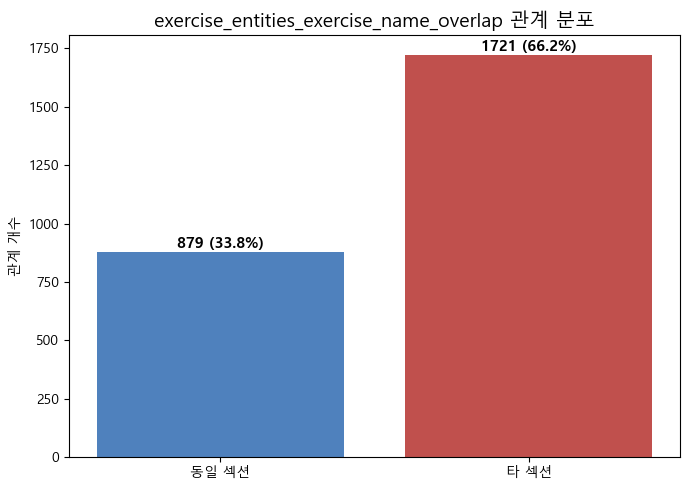

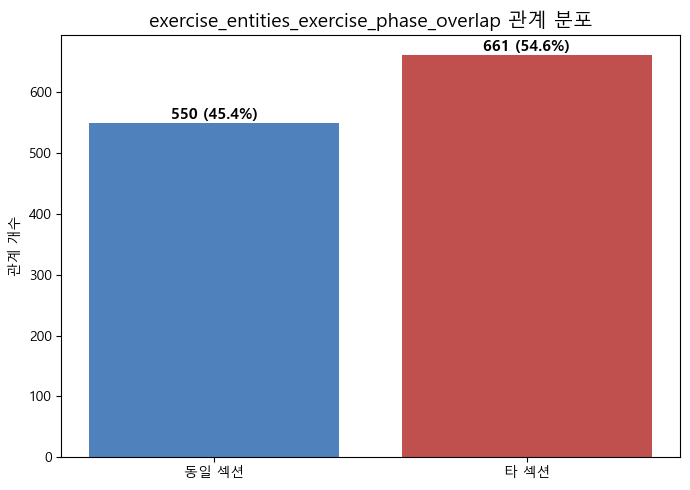

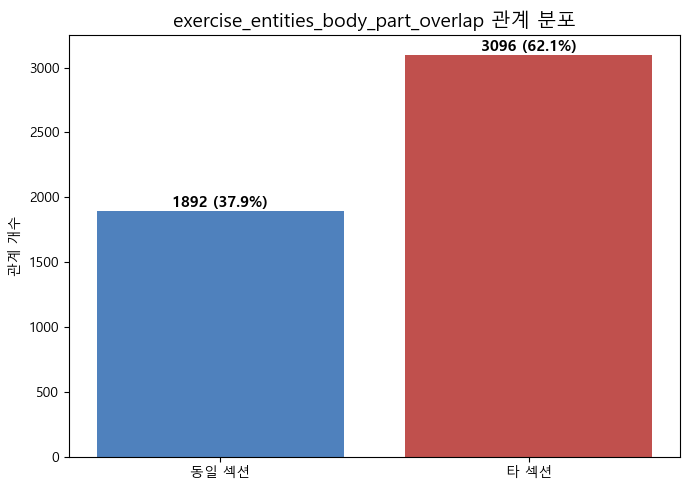

In [20]:
analyze_relationship(kg)

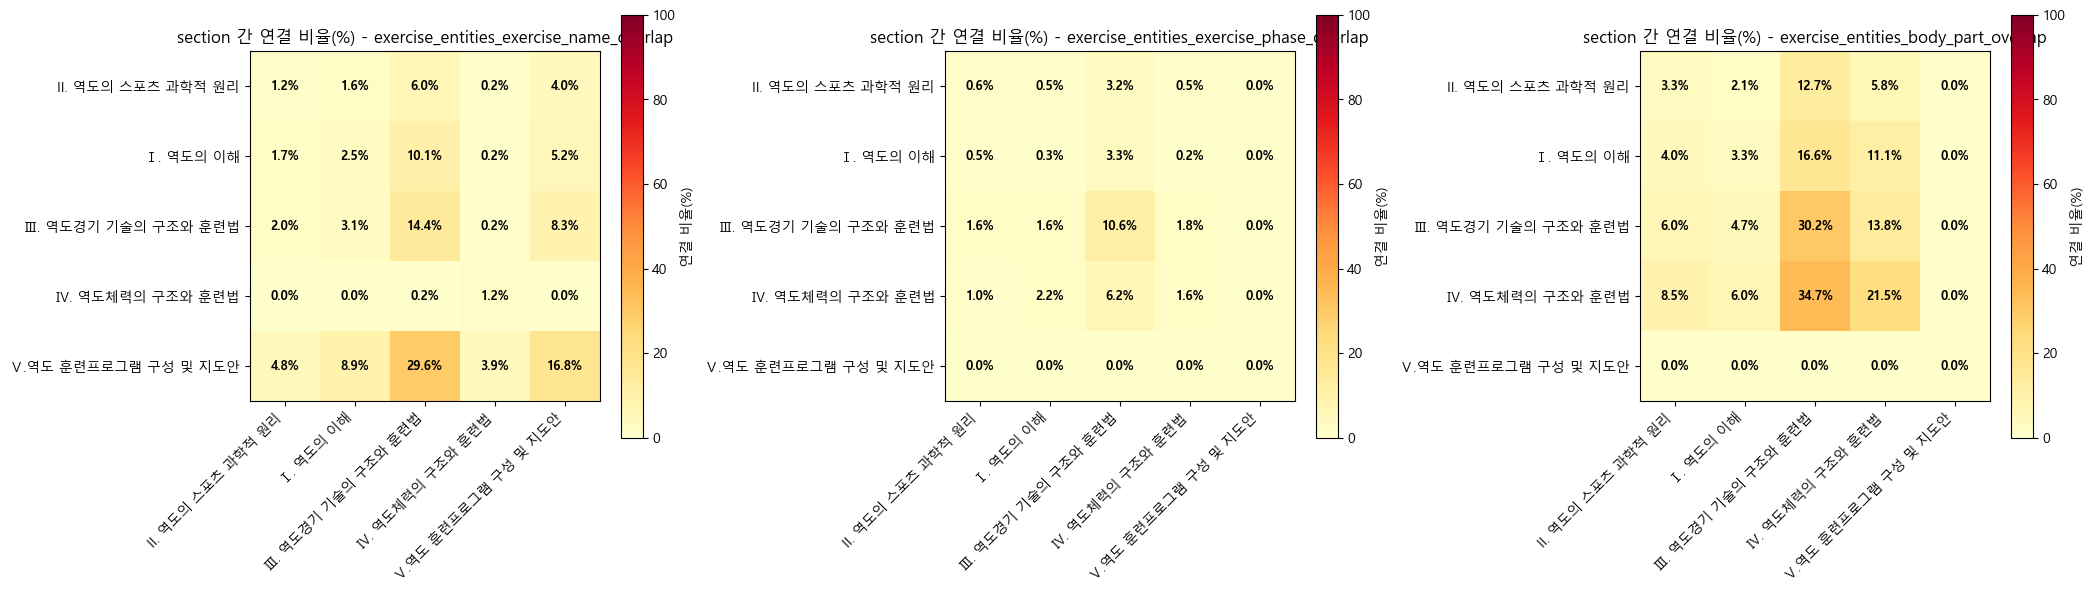

In [22]:
custom_rel_types = [
    'exercise_entities_exercise_name_overlap',
    'exercise_entities_exercise_phase_overlap',
    'exercise_entities_body_part_overlap'
]
dfs = analyze_sector_connection_ratio(
    kg,
    rel_types=custom_rel_types,
    figsize=(21, 6)  # 3개의 그래프를 위해 더 넓게
)

# Custom 시나리오 생성
* 모든 Custom 시나리오는 2개의 Chunk로 구성되며, 타 섹션간 결합
1. name_relation 
2. body_relation
3. name_relation, body_relation
4. name_relation, phase_relation





In [ ]:
def make_scenarios(kg: KnowledgeGraph, heading: str = 'heading1'):
    relations = [relation for relation in kg.relationships if relation.type in ['exercise_entities_exercise_name_overlap', 'exercise_entities_exercise_phase_overlap', 'exercise_entities_body_part_overlap']]

    diff = []
    key = []
    rel_type = []

    for relation in relations:
        dict_va =  relation.__dict__
        rel_type.append(dict_va['type']) 
        
        source = dict_va['source'].id.hex
        target = dict_va['target'].id.hex

        key.append('_'.join(sorted([source, target])))
        
        source_head = dict_va['source'].properties['document_metadata']['heading'][heading]
        target_head = dict_va['target'].properties['document_metadata']['heading'][heading]

        diff.append(not (source_head == target_head))
        
    relation_df = pd.DataFrame({'key': key, 'rel_type':rel_type, 'diff': diff})
    df = relation_df.loc[(relation_df['diff'] == True)].groupby(['rel_type'])['key'].unique().reset_index()

    # 각 관계 타입에 대한 데이터를 안전하게 추출
    name_overlap = df[df['rel_type'] == 'exercise_entities_exercise_name_overlap']['key'].iloc[0] if len(df[df['rel_type'] == 'exercise_entities_exercise_name_overlap']) > 0 else set()
    body_overlap = df[df['rel_type'] == 'exercise_entities_body_part_overlap']['key'].iloc[0] if len(df[df['rel_type'] == 'exercise_entities_body_part_overlap']) > 0 else set()
    phase_overlap = df[df['rel_type'] == 'exercise_entities_exercise_phase_overlap']['key'].iloc[0] if len(df[df['rel_type'] == 'exercise_entities_exercise_phase_overlap']) > 0 else set()

    # 각 케이스에 대한 계산
    nameOnly = list(set(name_overlap) - set(body_overlap) - set(phase_overlap))
    bodyOnly = list(set(body_overlap) - set(name_overlap) - set(phase_overlap))
    namePhase = list(set(name_overlap).intersection(set(phase_overlap)))
    nameBody = list(set(name_overlap).intersection(set(body_overlap)))

    return nameOnly, bodyOnly, namePhase, nameBody

In [23]:
nameOnly, bodyOnly, namePhase, nameBody = make_scenarios(kg, 'heading1')

In [27]:
print(len(nameOnly))
print(len(bodyOnly))
print(len(namePhase))
print(len(nameBody))

1189
2362
230
460


### CustomMultiHopScenario

In [28]:
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Any, Optional
import random

from ragas.testset.synthesizers.multi_hop import MultiHopQuerySynthesizer, MultiHopScenario
from ragas.testset.synthesizers.prompts import (
    ThemesPersonasInput,
    ThemesPersonasMatchingPrompt,
)
from ragas.testset.graph import KnowledgeGraph
from ragas.testset.persona import Persona
from ragas.testset.synthesizers.base import QueryStyle, QueryLength
from ragas.prompt import PydanticPrompt
from langchain.callbacks.base import Callbacks

In [29]:
@dataclass
class SingleRelationMultiHopScenario(MultiHopQuerySynthesizer):
    """
    Single relation type을 처리하는 MultiHopQuerySynthesizer
    """
    name: str = None
    relation_type: str = None
    relation_list: List[str] = field(default_factory=list)
    theme_persona_matching_prompt: PydanticPrompt = ThemesPersonasMatchingPrompt()

    def __post_init__(
        self,
        name: str = None,
        relation_type: str = None,
        relation_list: List[str] = None,
    ):
        if name is not None:
            self.name = name
        if relation_type is not None:
            self.relation_type = relation_type
        if relation_list is not None:
            self.relation_list = relation_list

    def get_node_clusters(self, knowledge_graph: KnowledgeGraph, heading: str) -> List[Tuple]:
        """
        Get node clusters based on relation type and relation list
        """
        return knowledge_graph.find_two_nodes_single_rel(
            relationship_condition=lambda rel: (
                rel.type == self.relation_type and 
                rel.source.id.hex in [r.split('_')[0] for r in self.relation_list] and
                rel.target.id.hex in [r.split('_')[1] for r in self.relation_list] and
                rel.source.properties['document_metadata']['heading'][heading] != rel.target.properties['document_metadata']['heading'][heading]
            )
        )
    
    def filter_keywords_by_statistics(
        self,
        count_dict: Dict[str, int],
        min_frequency: int = 2,
        percentile_threshold: float = 0.25
    ) -> Dict[str, int]:
        if not count_dict:
            return {}

        # 최소 빈도수로 필터링
        filtered_dict = {
            k: v for k, v in count_dict.items() 
            if v >= min_frequency
        }

        if not filtered_dict:
            return {}

        # 빈도수 값들의 평균과 표준편차 계산
        values = list(filtered_dict.values())
        mean = sum(values) / len(values)
        std = (sum((x - mean) ** 2 for x in values) / len(values)) ** 0.5

        # z-score 계산 및 하위 percentile_threshold% 제거
        z_scores = {k: (v - mean) / std for k, v in filtered_dict.items()}
        cutoff_z = sorted(z_scores.values())[int(len(z_scores) * percentile_threshold)]
        
        # z-score가 cutoff_z보다 큰 키워드만 유지
        filtered_dict = {
            k: v for k, v in filtered_dict.items()
            if z_scores[k] > cutoff_z
        }
        
        return filtered_dict

    async def _generate_scenarios(
        self,
        n: int,
        knowledge_graph: KnowledgeGraph,
        persona_list: List[Persona],
        callbacks: Callbacks,
        heading: str = 'heading1'
    ) -> List[MultiHopScenario]:
        # 1. 노드 클러스터 가져오기
        node_clusters = self.get_node_clusters(knowledge_graph, heading)
        
        if len(node_clusters) == 0:
            raise ValueError("No clusters found in the knowledge graph.")

        # 2. 카운트 딕셔너리와 캐시 초기화
        count_dict = {}
        overlapped_item_cache = {}

        # 3. overlapped_items 수집 및 카운팅
        for rel in node_clusters:
            overlap_items = rel[1].properties['overlapped_items']
            
            unique_items = list(set(sum(overlap_items, [])))
            overlap_item = random.choice(unique_items)
            
            if overlap_item in count_dict:
                count_dict[overlap_item] += 1
                overlapped_item_cache[overlap_item].append(rel)
            else:
                count_dict[overlap_item] = 1
                overlapped_item_cache[overlap_item] = [rel]

        # 4. 키워드 필터링
        count_dict = self.filter_keywords_by_statistics(
            count_dict,
            min_frequency=2,
            percentile_threshold=0.25
        )
        overlapped_item_cache = {
            k: v for k, v in overlapped_item_cache.items() 
            if k in count_dict
        }
        keywords = list(count_dict.keys())

        # 5. 페르소나-테마 매칭
        prompt_input = ThemesPersonasInput(
            themes=keywords,
            personas=persona_list
        )
        persona_concepts = await self.theme_persona_matching_prompt.generate(
            data=prompt_input,
            llm=self.llm,
            callbacks=callbacks
        )

        # 6. 페르소나별 키워드 매핑
        persona_keywords = {}
        for persona_name, persona_themes in persona_concepts.mapping.items():
            matching_keywords = [
                keyword for keyword in keywords 
                if any(keyword.lower() == theme.lower() for theme in persona_themes)
            ]
            if matching_keywords:
                persona_keywords[persona_name] = matching_keywords

        if not persona_keywords:
            raise ValueError("No valid persona-keyword combinations found.")

        # 7. 시나리오 생성
        scenarios = []
        persona_scenario_counts = {persona_name: 0 for persona_name in persona_keywords.keys()}

        # 모든 가능한 조합을 미리 생성
        valid_combinations = []
        for persona_name, keywords in persona_keywords.items():
            for keyword in keywords:
                if keyword in overlapped_item_cache:
                    for rel in overlapped_item_cache[keyword]:
                        valid_combinations.append({
                            'persona_name': persona_name,
                            'keyword': keyword,
                            'nodes': (rel[0], rel[2])
                        })

        # 조합을 랜덤하게 섞기
        random.shuffle(valid_combinations)

        # 시나리오 생성
        for combo in valid_combinations:
            if len(scenarios) >= n:
                break

            persona_name = combo['persona_name']
            keyword = combo['keyword']
            nodes = combo['nodes']

            selected_persona = next((p for p in persona_list if p.name == persona_name), None)
            if selected_persona is None:
                continue

            style = random.choice(list(QueryStyle))
            length = random.choice(list(QueryLength))

            scenario = MultiHopScenario(
                nodes=[nodes[0], nodes[1]],
                combinations=[keyword],
                persona=selected_persona,
                style=style,
                length=length
            )
            scenarios.append(scenario)
            persona_scenario_counts[persona_name] += 1

        return scenarios[:n]

In [30]:
@dataclass
class MultiRelationMultiHopScenario(MultiHopQuerySynthesizer):
    """
    Multiple relation types를 처리하는 MultiHopQuerySynthesizer
    """
    name: str = None
    relation_types: List[str] = field(default_factory=list)
    theme_persona_matching_prompt: PydanticPrompt = ThemesPersonasMatchingPrompt()
    relation_list: List[str] = field(default_factory=list)

    def __post_init__(
        self,
        name: str = None,
        relation_types: List[str] = None,
        relation_list: List[str] = None,
    ):
        if name is not None:
            self.name = name
        if relation_types is not None:
            self.relation_types = relation_types
        if relation_list is not None:
            self.relation_list = relation_list

    def filter_keywords_by_statistics(
        self,
        count_dict: Dict[str, int],
        min_frequency: int = 2,
        percentile_threshold: float = 0.25
    ) -> Dict[str, int]:
        if not count_dict:
            return {}

        # 최소 빈도수로 필터링
        filtered_dict = {
            k: v for k, v in count_dict.items() 
            if v >= min_frequency
        }

        if not filtered_dict:
            return {}

        # 빈도수 값들의 평균과 표준편차 계산
        values = list(filtered_dict.values())
        mean = sum(values) / len(values)
        std = (sum((x - mean) ** 2 for x in values) / len(values)) ** 0.5

        # z-score 계산 및 하위 percentile_threshold% 제거
        z_scores = {k: (v - mean) / std for k, v in filtered_dict.items()}
        cutoff_z = sorted(z_scores.values())[int(len(z_scores) * percentile_threshold)]
        
        # z-score가 cutoff_z보다 큰 키워드만 유지
        filtered_dict = {
            k: v for k, v in filtered_dict.items()
            if z_scores[k] > cutoff_z
        }
        
        return filtered_dict

    def get_node_clusters(self, knowledge_graph: KnowledgeGraph, heading: str) -> List[Tuple]:
        """
        Get node clusters based on relation types and relation list
        """
        node_clusters = knowledge_graph.find_two_nodes_single_rel(
            relationship_condition=lambda rel: (
                rel.type in [self.relation_types] and 
                rel.source.id.hex in [r.split('_')[0] for r in self.relation_list] and
                rel.target.id.hex in [r.split('_')[1] for r in self.relation_list] and
                rel.source.properties['document_metadata']['heading'][heading] != rel.target.properties['document_metadata']['heading'][heading]
            )
        )

        # source-target 쌍별로 관계 타입을 그룹화
        node_groups = {}
        for node in node_clusters:
            source_id = node[0].id.hex
            target_id = node[2].id.hex
            rel_type = node[1].type
            key = (source_id, target_id)
            
            if key not in node_groups:
                node_groups[key] = set()
            node_groups[key].add(rel_type)
        
        # 모든 relation_types를 포함하는 source-target 쌍만 필터링
        valid_keys = {
            key for key, rel_types in node_groups.items() 
            if set(self.relation_types).issubset(rel_types)
        }
        
        return [
            node for node in node_clusters 
            if (node[0].id.hex, node[2].id.hex) in valid_keys
        ]

    async def _generate_scenarios(
        self,
        n: int,
        knowledge_graph: KnowledgeGraph,
        persona_list: List[Persona],
        callbacks: Callbacks,
        heading: str = 'heading1'
    ) -> List[MultiHopScenario]:
        # 1. 노드 클러스터 가져오기
        node_clusters = self.get_node_clusters(knowledge_graph)

        if len(node_clusters) == 0:
            raise ValueError(
                "No clusters found in the knowledge graph. Check relation types and relation list."
            )
        
        # 2. 관계 타입별로 카운트 딕셔너리와 캐시 초기화
        count_dict = {rel_type: {} for rel_type in self.relation_types}
        overlapped_item_cache = {rel_type: {} for rel_type in self.relation_types}

        # 3. overlapped_items 수집 및 카운팅
        for rel in node_clusters:
            rel_type = rel[1].type
            overlap_items = rel[1].properties['overlapped_items']
            
            
            unique_items = list(set(sum(overlap_items, [])))
            overlap_item = random.choice(unique_items)
            
            if overlap_item in count_dict[rel_type]:
                count_dict[rel_type][overlap_item] += 1
                overlapped_item_cache[rel_type][overlap_item].append(rel)
            else:
                count_dict[rel_type][overlap_item] = 1
                overlapped_item_cache[rel_type][overlap_item] = [rel]

        # 4. 각 관계 타입별로 필터링
        keywords = []
        for rel_type in self.relation_types:
            count_dict[rel_type] = self.filter_keywords_by_statistics(
                count_dict[rel_type],
                min_frequency=2,
                percentile_threshold=0.25
            )
            overlapped_item_cache[rel_type] = {
                k: v for k, v in overlapped_item_cache[rel_type].items() 
                if k in count_dict[rel_type]
            }
            keywords.extend(list(count_dict[rel_type].keys()))
        
        # 5. 페르소나-테마 매칭
        prompt_input = ThemesPersonasInput(
            themes=keywords,
            personas=persona_list
        )
        persona_concepts = await self.theme_persona_matching_prompt.generate(
            data=prompt_input,
            llm=self.llm,
            callbacks=callbacks
        )

        # 6. 페르소나별 relation_type 키워드 매핑
        persona_relation_keywords = {}
        for persona_name, persona_themes in persona_concepts.mapping.items():
            persona_relation_keywords[persona_name] = {}
            
            for rel_type in self.relation_types:
                rel_type_keywords = count_dict[rel_type].keys()
                
                # 완벽한 키워드 매칭만 허용
                matching_keywords = [
                    keyword for keyword in rel_type_keywords 
                    if any(keyword.lower() == theme.lower() for theme in persona_themes)
                ]
                
                persona_relation_keywords[persona_name][rel_type] = matching_keywords

        # 7. 유효한 페르소나 필터링
        valid_personas = {
            persona_name: rel_types 
            for persona_name, rel_types in persona_relation_keywords.items()
            if all(len(keywords) > 0 for keywords in rel_types.values())
        }

        if not valid_personas:
            raise ValueError(
                "No valid persona-keyword combinations found. Check if the themes match with relation types."
            )
        
        # 8. 시나리오 생성
        scenarios = []
        persona_scenario_counts = {persona_name: 0 for persona_name in valid_personas.keys()}

        # relation_list를 랜덤하게 섞기
        random.shuffle(self.relation_list)
        
        for relation in self.relation_list:
            source = relation.split('_')[0]
            target = relation.split('_')[1]

            # 9. 관계 검색
            searched_relations = knowledge_graph.find_two_nodes_single_rel(
                relationship_condition=lambda rel: (
                    rel.type in self.relation_types and 
                    rel.source.id.hex == source and
                    rel.target.id.hex == target
                )
            )

            # 10. 관계 타입별 overlapped_items 수집
            relation_items = {}
            for rel in searched_relations:
                source_node, relationship, target_node = rel
                rel_type = relationship.type
                overlap_items = relationship.properties['overlapped_items']

                unique_items = list(set(sum(overlap_items, [])))
                overlap_item = random.choice(unique_items)
                relation_items[rel_type] = {
                    'items': [overlap_item],
                    'nodes': (source_node, target_node)
                }

            # 11. 필요한 모든 relation_type이 있는지 확인
            if not relation_items or not all(rel_type in relation_items for rel_type in self.relation_types):
                continue

            # 12. 각 페르소나에 대해 시나리오 생성 시도
            for persona_name, rel_type_keywords in valid_personas.items():
                valid_combinations = {}
                
                # 13. 각 relation_type에 대해 완벽한 키워드 매칭 확인
                for rel_type, keywords in rel_type_keywords.items():
                    if rel_type in relation_items:
                        item = relation_items[rel_type]['items'][0]
                        matching_keyword = next(
                            (keyword for keyword in keywords 
                             if keyword.lower() == item.lower()),
                            None
                        )
                        if matching_keyword:
                            valid_combinations[rel_type] = {
                                'keyword': matching_keyword,
                                'nodes': relation_items[rel_type]['nodes']
                            }

                # 14. 모든 relation_type에 대해 유효한 조합이 있는 경우 시나리오 생성
                if all(rel_type in valid_combinations for rel_type in self.relation_types):
                    style = random.choice(list(QueryStyle))
                    length = random.choice(list(QueryLength))
                    
                    ordered_combinations = [
                        valid_combinations[rel_type]['keyword'] 
                        for rel_type in self.relation_types
                    ]
                    
                    selected_persona = next((p for p in persona_list if p.name == persona_name), None)
                    if selected_persona is None:
                        raise ValueError(f"Persona with name {persona_name} not found in persona_list")

                    scenario = MultiHopScenario(
                        nodes=[valid_combinations[self.relation_types[0]]['nodes'][0], 
                            valid_combinations[self.relation_types[0]]['nodes'][1]],
                        combinations=ordered_combinations,
                        persona=selected_persona,
                        style=style,
                        length=length
                    )
                    scenarios.append(scenario)
                    persona_scenario_counts[persona_name] += 1
                    break

            if len(scenarios) >= n:
                break

        return scenarios[:n]

In [32]:
from ragas.testset import TestsetGenerator

query_distribution = [
    (SingleRelationMultiHopScenario(llm=generator_llm, relation_list=nameOnly, name='exercise name', relation_type='exercise_entities_exercise_name_overlap'), 0.25),
    (SingleRelationMultiHopScenario(llm=generator_llm, relation_list=bodyOnly, name='body part', relation_type='exercise_entities_body_part_overlap'), 0.25),
    (MultiRelationMultiHopScenario(llm=generator_llm, relation_list=namePhase, name='exercise name, exercise phase', relation_types=['exercise_entities_exercise_name_overlap', 'exercise_entities_exercise_phase_overlap']), 0.25),
    (MultiRelationMultiHopScenario(llm=generator_llm, relation_list=nameBody, name='exercise name, body part', relation_types=['exercise_entities_exercise_name_overlap', 'exercise_entities_body_part_overlap']), 0.25),
]

generator = TestsetGenerator(
    llm=generator_llm,
    embedding_model=generator_embeddings,
    knowledge_graph=kg,
    persona_list=personas,
)

In [33]:
# testset = generator.generate(testset_size=50, query_distribution=query_distribution)
test_df = testset.to_pandas()
# test_df.to_csv('../data/document/역도/customDataset.csv', index=False)

Generating Scenarios:  25%|██▌       | 1/4 [00:04<00:13,  4.49s/it]

{'Weightlifting Performance Optimizer': {'exercise_entities_exercise_name_overlap': ['스내치', '클린'], 'exercise_entities_exercise_phase_overlap': ['준비자세', '구간 단위', '두 번째 당기기', '받기 동작', '스타트', '끌기', '첫 번째 당기기']}, 'Fitness Gym Novice': {'exercise_entities_exercise_name_overlap': [], 'exercise_entities_exercise_phase_overlap': ['준비자세', '받기 동작', '스타트', '첫 번째 당기기']}, 'Middle-Aged Beginner': {'exercise_entities_exercise_name_overlap': ['클린'], 'exercise_entities_exercise_phase_overlap': ['두 번째 당기기', '받기 동작', '스타트', '첫 번째 당기기']}}


Generating Scenarios:  50%|█████     | 2/4 [00:12<00:13,  6.56s/it]

{'Weightlifting Performance Optimizer': {'exercise_entities_exercise_name_overlap': ['클린', '저크', '클린 앤 저크'], 'exercise_entities_body_part_overlap': ['다리', '몸통', '상체']}, 'Fitness Gym Novice': {'exercise_entities_exercise_name_overlap': ['클린', '저크'], 'exercise_entities_body_part_overlap': ['다리', '몸통', '상체']}, 'Middle-Aged Beginner': {'exercise_entities_exercise_name_overlap': [], 'exercise_entities_body_part_overlap': ['팔', '다리', '무릎', '엉덩이', '어깨']}}


Generating Samples: 100%|██████████| 62/62 [00:17<00:00,  3.49it/s]


In [35]:
test_df['synthesizer_name'].unique()

array(['exercise name', 'body part', 'exercise name, exercise phase',
       'exercise name, body part'], dtype=object)

In [36]:
test_df.loc[(test_df['synthesizer_name'] == 'exercise name, exercise phase')]

,user_input,reference_contexts,reference,synthesizer_name
26,스내치의 준비자세에서 허리의 S자형을 유지하는 것이 왜 중요한가?,"[<1-hop>\n\n결국, 그 말의 의미는 시작자세가 마지막 받는 동작에 영향을 ...","스내치의 준비자세에서 허리의 S자형을 유지하는 것이 중요한 이유는, 허리가 S자형을...","exercise name, exercise phase"
27,What is the significance of the first pull in ...,[<1-hop>\n\n앉아받기란 잡아채기 동작을 실행한 다음 선수의 몸체를 바벨 아...,"The first pull, often referred to as the lift ...","exercise name, exercise phase"
28,"스내치에서 준비자세의 중요성은 무엇이며, 바벨의 수직위치를 발가락이 아닌 발바닥 중...","[<1-hop>\n\n선수 대부분은 발가락을 옆으로 향하게 한 채로 서며, 이것은 ...","스내치에서 준비자세는 매우 중요하며, 바벨의 수직위치를 발가락이 아닌 발바닥 중앙에...","exercise name, exercise phase"
29,스내치에서 준비자세의 중요성과 선수의 신체적 특성이 어떻게 영향을 미치는가?,"[<1-hop>\n\n선수 대부분은 발가락을 옆으로 향하게 한 채로 서며, 이것은 ...","스내치에서 준비자세는 선수의 신체적 특성에 따라 달라지며, 이는 대회에서의 성과에 ...","exercise name, exercise phase"
30,What biomechanical adjustments are necessary d...,[<1-hop>\n\n지면을 정확히 눌러 큰 지면반력을 얻기 위해 발목관절이 일직선...,To achieve optimal posture and movement effici...,"exercise name, exercise phase"
31,스내치에서 첫 번째 당기기 동작이 효율적인 시작자세와 어떻게 연결되는가?,[<1-hop>\n\n이러한 현\n상은 위에서 언급한 효율적인 시작자세와도 관련이 ...,스내치에서 첫 번째 당기기 동작은 효율적인 시작자세와 밀접한 관련이 있다. 시작자세...,"exercise name, exercise phase"
32,스내치에서 준비자세가 선수의 경기력에 미치는 영향은 무엇인가요? 특히 스타트 시의 ...,[<1-hop>\n\n시작자세는 선수마다 정도의 차이는 있겠지만 경기력에 많은 부분...,스내치에서 준비자세는 선수의 경기력에 매우 중요한 영향을 미친다. 시작자세는 바벨을...,"exercise name, exercise phase"
33,"스내치에서 첫 번째 당기기 단계의 기술적 요소는 무엇이며, 앉아받기 동작에서 바벨을...",[<1-hop>\n\n끌기자세는 무릎 밑에서 고관절까지 바벨을 들어 올린 지점까지로...,스내치에서 첫 번째 당기기 단계는 바벨을 자기중심 안으로 최대한 밀착시켜 수직상향으...,"exercise name, exercise phase"
34,What are the key technical aspects of the 스타트 ...,[<1-hop>\n\n역도의 기술을 습득하고 효율적인 올 바른 지도를 하기 위해서는...,The 스타트 phase in 스내치 is crucial for effective ...,"exercise name, exercise phase"
35,What are the key components of the 준비자세 (prepa...,[<1-hop>\n\n순간적으로 무거운 물체를 들어 올리는 데에는 근력 외에도 강인...,The key components of the 준비자세 (preparatory po...,"exercise name, exercise phase"


In [37]:
test_df.loc[(test_df['synthesizer_name'] == 'exercise name, body part')]

,user_input,reference_contexts,reference,synthesizer_name
51,What are the biomechanical considerations for ...,[<1-hop>\n\n지면을 정확히 눌러 큰 지면반력을 얻기 위해 발목관절이 일직선...,"To achieve an effective jerk in weightlifting,...","exercise name, body part"
52,저크를 수행할 때 몸통의 올바른 신전과 균형 유지가 어떻게 이루어지는지 설명해줘.,[<1-hop>\n\n순간적으로 무거운 물체를 들어 올리는 데에는 근력 외에도 강인...,저크를 수행할 때 몸통의 올바른 신전은 바벨을 폭발적으로 위로 올린 후 몸통과 팔을...,"exercise name, body part"
53,What are the key components of the Jerk moveme...,[<1-hop>\n\n순간적으로 무거운 물체를 들어 올리는 데에는 근력 외에도 강인...,The key components of the Jerk movement in wei...,"exercise name, body part"
54,What is the importance of maintaining a proper...,[<1-hop>\n\n다만 너무 많이 굽히면 부상을 당할 수 있으므로 연습 시 적정...,Maintaining a proper body posture during the j...,"exercise name, body part"
55,What are the key biomechanical considerations ...,[<1-hop>\n\n지면을 정확히 눌러 큰 지면반력을 얻기 위해 발목관절이 일직선...,To optimize the jerk technique in weightliftin...,"exercise name, body part"
56,What are the key biomechanical aspects of the ...,[<1-hop>\n\n순간적으로 무거운 물체를 들어 올리는 데에는 근력 외에도 강인...,"In the Clean and Jerk technique, particularly ...","exercise name, body part"
57,"저크 동작에서 다리를 어떻게 정확히 벌려야 하며, 장미란 선수의 특성과 관련하여 어...",[<1-hop>\n\n지면을 정확히 눌러 큰 지면반력을 얻기 위해 발목관절이 일직선...,저크 동작에서 다리를 정확히 벌리기 위해서는 Jerk Split 자세를 취해야 하며...,"exercise name, body part"
58,저크 동작에서 몸통의 올바른 자세를 유지하기 위해 선수들이 어떤 동작을 수행해야 하...,[<1-hop>\n\n저크동작은 용상에만 있는 동작으로 클린에 비하여 실패율이 2배...,저크 동작에서 몸통의 올바른 자세를 유지하기 위해 선수들은 바벨을 폭발적으로 위로 ...,"exercise name, body part"
59,저크 동작에서 다리를 어떻게 벌려야 바벨을 안정적으로 고정할 수 있나요?,[<1-hop>\n\n순간적으로 무거운 물체를 들어 올리는 데에는 근력 외에도 강인...,저크 동작에서 다리를 벌리는 것은 Jerk Split 자세에서 중요한 요소입니다. ...,"exercise name, body part"
60,"저크의 시작자세에서 몸통의 올바른 위치는 어떻게 되며, 이 자세가 저크의 성공에 어...",[<1-hop>\n\n순간적으로 무거운 물체를 들어 올리는 데에는 근력 외에도 강인...,"저크의 시작자세에서 몸통은 중앙이나 조금 뒤에 위치해야 하며, 이는 바벨이 앞에 위...","exercise name, body part"


In [39]:
trans_df = translate(test_df)
result = analyze_synthetic_data(kg, test_df)
# test_df.to_csv('../data/document/역도/customDataset.csv', index=False)

In [41]:
result

,user_input,reference_contexts,reference,synthesizer_name,reference_contexts_section
0,"스내치 훈련의 예비자세를 준비하기 위해 어떤 동작들이 필요하며, 장미란 선수의 동작...",[<1-hop>\n\n지면을 정확히 눌러 큰 지면반력을 얻기 위해 발목관절이 일직선...,"스내치 훈련의 예비자세를 준비하기 위해서는 바에 가까이 접근하고, 머리를 자연스럽게...",exercise name,"[II. 역도의 스포츠 과학적 원리, Ⅲ. 역도경기 기술의 구조와 훈련법]"
1,"한국 선수와 중국 코치의 스내치 스타트 자세 차이점이 뭐고, 그 자세가 왜 중요한지...",[<1-hop>\n\n이미지에는 한국 선수와 중국 코치의 스타트 자세 차이점이 나타...,한국 선수는 허리를 S자 모양으로 유지하고 상체를 앞으로 기울이지 않으며 어깨를 안...,exercise name,"[II. 역도의 스포츠 과학적 원리, Ⅲ. 역도경기 기술의 구조와 훈련법]"
2,클린 앤 저크의 동작에서 Jerk Dip 자세를 취할 때 선수는 어떤 자세를 유지해...,[<1-hop>\n\n선수는 양다리를 구부리고 바벨을 양팔을 수직으로 뻗어 완전히 ...,클린 앤 저크의 동작에서 Jerk Dip 자세를 취할 때 선수는 아래로 무릎을 굽힐...,exercise name,"[Ⅰ. 역도의 이해, Ⅲ. 역도경기 기술의 구조와 훈련법]"
3,저크를 위한 무릎 굽힘이 일어날 때 바벨이 힘의 중심선에 위치하게 하려면 어떤 자세...,"[<1-hop>\n\n8) 머리는 뒤로 젖히지 말고 편안하게 자세를 취하며, 턱은 ...",저크를 위한 무릎 굽힘이 일어날 때 바벨이 힘의 중심선에 위치하게 하려면 발목관절이...,exercise name,"[Ⅲ. 역도경기 기술의 구조와 훈련법, II. 역도의 스포츠 과학적 원리]"
4,"스내치의 시작자세에서 한국 선수와 중국 코치의 차이점은 무엇이며, 이러한 차이가 스...","[<1-hop>\n\n결국, 그 말의 의미는 시작자세가 마지막 받는 동작에 영향을 ...",스내치의 시작자세에서 한국 선수는 허리를 S자 모양으로 유지하고 상체를 앞으로 기울...,exercise name,"[Ⅲ. 역도경기 기술의 구조와 훈련법, II. 역도의 스포츠 과학적 원리]"
...,...,...,...,...,...
57,"저크 동작에서 다리를 어떻게 정확히 벌려야 하며, 장미란 선수의 특성과 관련하여 어...",[<1-hop>\n\n지면을 정확히 눌러 큰 지면반력을 얻기 위해 발목관절이 일직선...,저크 동작에서 다리를 정확히 벌리기 위해서는 Jerk Split 자세를 취해야 하며...,"exercise name, body part","[II. 역도의 스포츠 과학적 원리, Ⅲ. 역도경기 기술의 구조와 훈련법]"
58,저크 동작에서 몸통의 올바른 자세를 유지하기 위해 선수들이 어떤 동작을 수행해야 하...,[<1-hop>\n\n저크동작은 용상에만 있는 동작으로 클린에 비하여 실패율이 2배...,저크 동작에서 몸통의 올바른 자세를 유지하기 위해 선수들은 바벨을 폭발적으로 위로 ...,"exercise name, body part","[II. 역도의 스포츠 과학적 원리, Ⅲ. 역도경기 기술의 구조와 훈련법]"
59,저크 동작에서 다리를 어떻게 벌려야 바벨을 안정적으로 고정할 수 있나요?,[<1-hop>\n\n순간적으로 무거운 물체를 들어 올리는 데에는 근력 외에도 강인...,저크 동작에서 다리를 벌리는 것은 Jerk Split 자세에서 중요한 요소입니다. ...,"exercise name, body part","[Ⅰ. 역도의 이해, Ⅲ. 역도경기 기술의 구조와 훈련법]"
60,"저크의 시작자세에서 몸통의 올바른 위치는 어떻게 되며, 이 자세가 저크의 성공에 어...",[<1-hop>\n\n순간적으로 무거운 물체를 들어 올리는 데에는 근력 외에도 강인...,"저크의 시작자세에서 몸통은 중앙이나 조금 뒤에 위치해야 하며, 이는 바벨이 앞에 위...","exercise name, body part","[Ⅰ. 역도의 이해, Ⅲ. 역도경기 기술의 구조와 훈련법]"
